## Car Damage Detection and Segmentation

This notebook implements yolov11 segmentation to detect and isolate types of damage on cars. The dataset comes from https://cardd-ustc.github.io/

### Dependency Imports

In [1]:
from ultralytics import YOLO
import pandas as pd
import json
import os
import shutil

### Data Preprocessing

In [ ]:
# print("Formatting dataset...")

# # Create directory structure
# splits = ['train', 'val', 'test']
# for split in splits:
#     os.makedirs(f'../../dataset/CarDD_YOLO/{split}/images', exist_ok=True)
#     os.makedirs(f'../../dataset/CarDD_YOLO/{split}/labels', exist_ok=True)

#     # Load COCO annotations
#     with open(f'../../dataset/CarDD_COCO/annotations/instances_{split}2017.json', 'r') as f:
#         split_data = json.load(f)

#     images = split_data['images']
#     annotations = split_data['annotations']
    
#     # Group annotations by image_id (one image can have multiple annotations)
#     annotations_by_image = {}
#     for annotation in annotations:
#         image_id = annotation['image_id']
#         if image_id not in annotations_by_image:
#             annotations_by_image[image_id] = []
#         annotations_by_image[image_id].append(annotation)
    
#     print(f"\nProcessing {split} split: {len(images)} images, {len(annotations)} annotations")
    
#     for image in images:
#         image_name = image['file_name']
#         image_id = image['id']
#         width = image['width']
#         height = image['height']
        
#         # Copy image to YOLO directory
#         src_path = f'../../dataset/CarDD_COCO/{split}2017/{image_name}'
#         dst_path = f'../../dataset/CarDD_YOLO/{split}/images/{image_name}'
#         shutil.copy(src_path, dst_path)
        
#         # Create corresponding label file
#         label_name = os.path.splitext(image_name)[0] + '.txt'
#         label_path = f'../../dataset/CarDD_YOLO/{split}/labels/{label_name}'
        
#         # Get all annotations for this image
#         image_annotations = annotations_by_image.get(image_id, [])
        
#         with open(label_path, 'w') as label_file:
#             for annotation in image_annotations:
#                 # YOLO uses 0-indexed classes, COCO uses 1-indexed
#                 class_id = annotation['category_id'] - 1
                
#                 # Process each segmentation polygon
#                 for segmentation in annotation['segmentation']:
#                     # Normalize coordinates (YOLO format requires values between 0 and 1)
#                     normalized_coords = []
#                     for i in range(0, len(segmentation), 2):
#                         x = segmentation[i] / width
#                         y = segmentation[i + 1] / height
#                         normalized_coords.extend([x, y])
                    
#                     # Write to label file: class_id x1 y1 x2 y2 ... xn yn
#                     line = f"{class_id} " + " ".join([f"{coord:.6f}" for coord in normalized_coords])
#                     label_file.write(line + '\n')

# print("\nDataset conversion complete!")
# print("\nCategory mapping (YOLO class_id: name):")
# categories = split_data['categories']
# for cat in categories:
#     print(f"  {cat['id'] - 1}: {cat['name']}")

### Create YOLO Dataset Configuration

In [ ]:
# Create YOLO dataset configuration file
import yaml

dataset_config = {
    'path': '../../dataset/CarDD_YOLO',  # Dataset root directory
    'train': 'train/images',  # Training images
    'val': 'val/images',      # Validation images
    'test': 'test/images',    # Test images
    
    # Classes
    'names': {
        0: 'dent',
        1: 'scratch',
        2: 'crack',
        3: 'glass shatter',
        4: 'lamp broken',
        5: 'tire flat'
    }
}

config_path = '../../dataset/CarDD_YOLO/data.yaml'
with open(config_path, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(f"YOLO dataset configuration saved to: {config_path}")
print("\nDataset is ready for YOLO segmentation training!")

YOLO dataset configuration saved to: ../dataset/CarDD_YOLO/data.yaml

Dataset is ready for YOLO segmentation training!


### Train YOLOv11 Segmentation Model

In [ ]:
# Load a pretrained YOLOv11 segmentation model
model = YOLO('yolo11m-seg.pt')  # nano model for faster training, use yolo11s-seg.pt, yolo11m-seg.pt for better accuracy

results = model.train(
    data='../../dataset/CarDD_YOLO/data.yaml',
    epochs=50,
    imgsz=1280,          # consider 896–1024 later for tiny cracks
    batch=16,
    name='car_damage_seg_aug_v1',
    project='runs/segment',
    patience=10,
    save=True,
    plots=True,

    # ---- Geometric augs (gentle) ----
    degrees=5.0,        # small rotations, don't wreck orientation
    translate=0.05,     # up to 5% shift
    scale=0.15,         # ±15% zoom, avoids shrinking tiny damage to nothing
    shear=2.0,          # tiny shear only
    perspective=0.0005, # basically none; perspective hurts small features

    # ---- Color / exposure ----
    hsv_h=0.015,        # small hue jitter
    hsv_s=0.4,          # moderate saturation
    hsv_v=0.2,          # slight brightness jitter
    # DO NOT add motion blur / strong noise for this task

    # ---- Flips ----
    fliplr=0.5,         # horizontal flip (good)
    flipud=0.0,         # upside-down cars are pointless

    # ---- Advanced augs ----
    mosaic=0.3,         # lower than default; mosaic can kill tiny cracks
    mixup=0.05,         # tiny bit; too much mixup washes out damage
    copy_paste=0.2,     # can help if you paste damaged regions onto new cars
    erasing=0.15,       # light Cutout; don't hide huge chunks of the car

    auto_augment=None,  # turn off random policy so YOU control augs
)

New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.228  Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../dataset/CarDD_YOLO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_damage

### Evaluate Model Performance

In [ ]:
# Load the best trained model
best_model = YOLO('runs/segment/car_damage_seg/weights/best.pt')

# Validate the model on the test set
metrics = best_model.val(data='../../dataset/CarDD_YOLO/data.yaml', split='test')

print("\nTest Set Results:")
print(f"mAP50: {metrics.seg.map50:.4f}")
print(f"mAP50-95: {metrics.seg.map:.4f}")

Ultralytics 8.3.228  Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,738 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1066.4394.8 MB/s, size: 628.6 KB)
val: Scanning C:\git\classwork\csc_2611\projects\car_damage_classification\dataset\CarDD_YOLO\test\labels... 374 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 374/374 2.4Kit/s 0.2s<0.2s
val: New cache created: C:\git\classwork\csc_2611\projects\car_damage_classification\dataset\CarDD_YOLO\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 8.7it/s 2.8s<0.1s
                   all        374        785      0.602      0.648      0.653        0.5      0.615      0.645      0.647      0.474
                  dent        157        236      0.583      0.475      0.517      0.257      0.588      

### Run Inference on Test Images


image 1/374 c:\git\classwork\csc_2611\projects\car_damage_classification\car_damage_classification\..\dataset\CarDD_YOLO\test\images\000012.jpg: 448x640 1 tire flat, 41.2ms
image 2/374 c:\git\classwork\csc_2611\projects\car_damage_classification\car_damage_classification\..\dataset\CarDD_YOLO\test\images\000015.jpg: 448x640 2 scratchs, 8.8ms
image 3/374 c:\git\classwork\csc_2611\projects\car_damage_classification\car_damage_classification\..\dataset\CarDD_YOLO\test\images\000023.jpg: 448x640 1 dent, 11.1ms
image 4/374 c:\git\classwork\csc_2611\projects\car_damage_classification\car_damage_classification\..\dataset\CarDD_YOLO\test\images\000033.jpg: 640x448 1 dent, 52.5ms
image 5/374 c:\git\classwork\csc_2611\projects\car_damage_classification\car_damage_classification\..\dataset\CarDD_YOLO\test\images\000040.jpg: 448x640 1 scratch, 1 lamp broken, 6.9ms
image 6/374 c:\git\classwork\csc_2611\projects\car_damage_classification\car_damage_classification\..\dataset\CarDD_YOLO\test\images\0

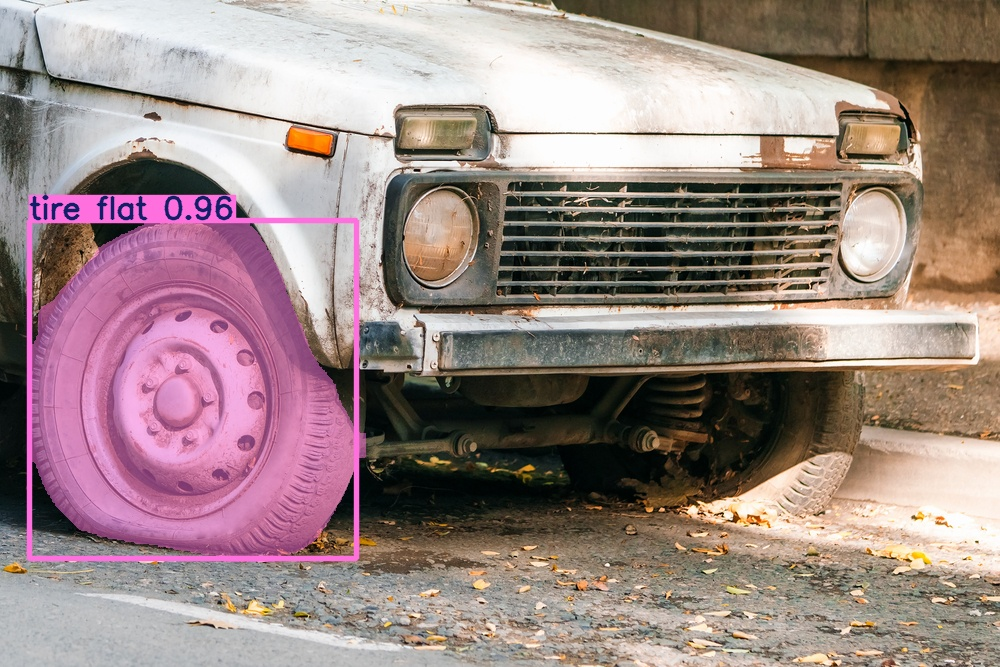

In [ ]:
# Run inference on test images
test_image_path = '../../dataset/CarDD_YOLO/test/images'

# Predict on a batch of test images
results = best_model.predict(
    source=test_image_path,
    save=True,  # Save annotated images
    conf=0.25,  # Confidence threshold
    project='runs/segment',
    name='predictions',
    exist_ok=True
)

print(f"\nProcessed {len(results)} images")
print(f"Results saved to: runs/segment/predictions")

# Display results for first image
from IPython.display import Image, display
import glob

pred_images = glob.glob('runs/segment/predictions/*.jpg')
if pred_images:
    print("\nSample prediction:")
    display(Image(filename=pred_images[0]))